<b>
<p>
<center>
<font size='5'>
LSTM for Predicting Traffic Volume
</font>
</center>
</p>

    
<p>
<center>
<font size='4'>
Time Series Project [Spring 2022 Session]
</font>
</center>
</p>

<p>
<center>
<font size='3'>
Data Science, Columbian College of Arts & Sciences, George Washington University
</font>
</center>
</p>

<p>
<center>
<font size='3'>
Osemekhian Solomon Ehilen
</font>
</center>
</p>
</b>

In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')
#"G:\My Drive\Colab Notebooks\code"

# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Time Series Project/'


Mounted at /content/drive


In [2]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras

# The random seed
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

In [3]:
# univariate stacked lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd 

In [4]:
# split a univariate sequence
def split_seq(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


## Importing Dataset

Missing Values: False


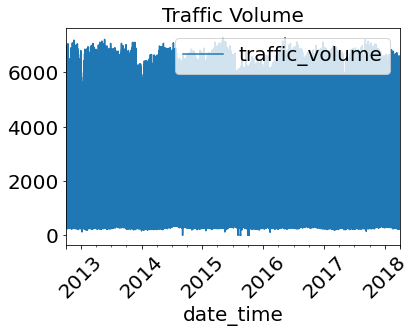

In [5]:
import os
os.chdir(abspath_curr + 'data/Metro_Interstate_Traffic_Volume.csv/')
df= pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df_copy= df.copy(deep=True)
datetime= pd.date_range(start='2012-10-02 09:00:00',
                        periods=len(df_copy), freq='1H') #set accurate date_range
df_copy['date_time']=datetime

#---------------Missing Values & transformation---------------------------------
print(f'Missing Values: {df_copy.isna().sum().any()}')

#---------------Dependent Variable time Plot-------------------
df_copy.plot(x='date_time',y='traffic_volume')
plt.title('Traffic Volume')
plt.xticks(rotation=45)
plt.show()

target='traffic_volume'

#----------------Splitting Dataset-----------------------------
from sklearn.model_selection import train_test_split
train,test= train_test_split(df_copy[target],train_size=0.8,shuffle=False)


In [6]:
df_copy

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-04-02 16:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-04-02 17:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-04-02 18:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-04-02 19:00:00,1450


In [46]:
# define input sequence
traffic_volume = train
# number of time steps
n_steps = 24 
# split into samples
X, y = split_seq(traffic_volume, n_steps)
train_y=y
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))


In [8]:
# ModelCheckpoint callback to_save_the_model
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/modelLSTM/LSTM.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True, monitor='loss')
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=6,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback #Performance Scheduling
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=2)

In [43]:
# define model Biderctional LSTM
model = Sequential()
#model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(keras.layers.Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
#model.add(LSTM(50, activation='relu'))
model.add(Dense(90,activation='relu'))
model.add(Dense(70,activation='relu'))
model.add(Dense(50,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 90)                9090      
                                                                 
 dense_4 (Dense)             (None, 70)                6370      
                                                                 
 dense_5 (Dense)             (None, 50)                3550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 39,861
Trainable params: 39,861
Non-trainable params: 0
__________________________________________________

## Saving model

In [44]:
# Make directory
directory = os.path.dirname(abspath_curr + '/modelLSTM/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [47]:
# fit model
history=model.fit(X,y, epochs=10, callbacks=[model_checkpoint_cb,
                                                         early_stopping_cb,reduce_lr_on_plateau_cb],
                                                        validation_split=0.2)

Epoch 1/10
964/964 [==============================] - 75s 78ms/step - loss: 1503981.3750 - val_loss: 954234.8125 - lr: 0.0010
Epoch 2/10
964/964 [==============================] - 74s 76ms/step - loss: 2532186.0000 - val_loss: 1502302.3750 - lr: 0.0010
Epoch 3/10
964/964 [==============================] - 74s 77ms/step - loss: 1627304.5000 - val_loss: 1468555.2500 - lr: 0.0010
Epoch 4/10
964/964 [==============================] - 74s 77ms/step - loss: 1234758.1250 - val_loss: 993209.0625 - lr: 1.0000e-04
Epoch 5/10
964/964 [==============================] - 74s 77ms/step - loss: 1082706.5000 - val_loss: 855656.2500 - lr: 1.0000e-04
Epoch 6/10
964/964 [==============================] - 74s 76ms/step - loss: 976253.9375 - val_loss: 761405.1250 - lr: 1.0000e-04
Epoch 7/10
964/964 [==============================] - 74s 77ms/step - loss: 961559.5000 - val_loss: 1069841.8750 - lr: 1.0000e-04
Epoch 8/10
964/964 [==============================] - 73s 75ms/step - loss: 1092752.1250 - val_loss: 

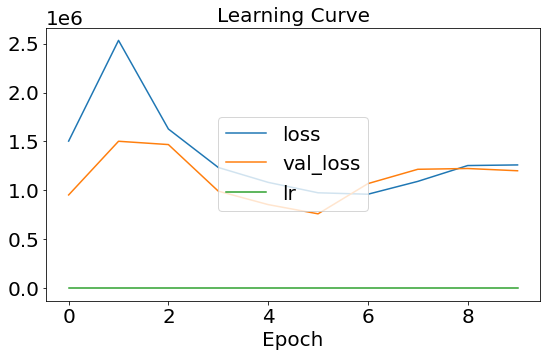

In [48]:
#Check loss and accuracy
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Save and show the figure
plt.tight_layout()
plt.legend(loc='center')
plt.title("Learning Curve")
plt.xlabel('Epoch')
plt.show()

In [49]:
# demonstrate prediction
x_input =  X #array([90])
x_input = x_input.reshape((-1, n_steps, n_features))

pred = model.predict(x_input)
print(pred)

[[5393.9277]
 [4904.466 ]
 [5098.757 ]
 ...
 [1874.2981]
 [2055.4473]
 [2325.6045]]


In [50]:
from sklearn.metrics import mean_squared_error
print(f'MSE prediction: {mean_squared_error(y,pred)}')

MSE prediction: 1251498.2047935843


In [51]:
#Auto-Correlation Function (ACF)
def ACF(array,lag,label):
    """
    This returns the Autocorrelation of a time series data.
    Print 'ac' to get autocorrelation coefficients

    Parameters
    ----------
    :param array :  Array of Time Series Data
    :param lag : Number of Lags
    :param label : Title
    """
    global ac
    mu= np.mean(array)
    var=0;Rt=0;ac=[]
    var= sum(map(lambda x:(x-mu)**2,array))
    for j in range(lag):
        for i in range((j),len(array)):
            Rt += (array[i]-mu)*(array[i-j]-mu)
        ac.append(round(Rt/var,4))
        Rt=0
    ry= ac[::-1][:-1] + ac
    plt.stem(np.linspace(-((len(ac))-1), len(ac)-1, (len(ac)*2-1), dtype=int), ry, markerfmt='o')
    plt.axhspan(-(1.96/np.sqrt(len(array))), (1.96/np.sqrt(len(array))), alpha=0.2, color='blue')
    plt.title(f'Autocorrelation Function of {label}')
    plt.ylabel('Magnitude'); plt.xlabel('Lags')
    plt.show()


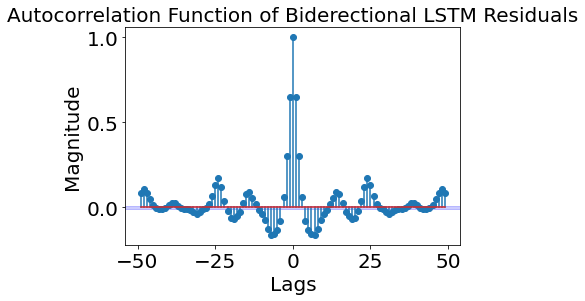

Variance of Residual: 2001939


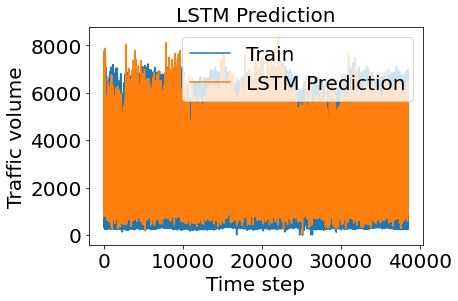

In [92]:
residual=y.ravel()[1:]-pred.ravel()[:-1]
ACF(residual,50,'Biderectional LSTM Residuals')
print(f'Variance of Residual: {round(np.var(residual))}')

plt.plot(y.ravel()[1:],label='Train')
plt.plot(pred.ravel()[:-1],label='LSTM Prediction')
plt.legend()
plt.ylabel('Traffic volume')
plt.xlabel('Time step')
plt.title('LSTM Prediction')
plt.show()

In [53]:
import statsmodels.api as sm
Q= sm.stats.acorr_ljungbox(residual, lags=[50])
print(f'Qvalue: {Q}')

Qvalue: (array([28721.48425235]), array([0.]))


In [54]:
test

38563    2704
38564    2704
38565    2204
38566    2204
38567    1713
         ... 
48199    3543
48200    2781
48201    2159
48202    1450
48203     954
Name: traffic_volume, Length: 9641, dtype: int64

In [55]:
# split a univariate sequence
def split_seq(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


In [63]:
forecast_main=[]
last24=train[len(train)-9600:].ravel().tolist()
for i in range(len(test)):#last 1 month for next 1 month forecast
  # define input sequence
  take=last24[len(last24)-9600:]
  traffic_volume = take


  # # demonstrate forecast
  forecast = model.predict(array(traffic_volume).reshape((-1,24,1)))
  forecast_main.append(forecast[0][0])
  last24.append(forecast[0][0])

In [88]:
forecast_main= array(forecast_main).astype('int')
print(forecast_main[:25])
print(len(forecast_main))

[3360 2517 2415 2046 1665 1110 1048 1438 1977 1600 1332 1262 1281 1177
 1088 1117  688  777  530  571  518  582  448  500  599]
9641


In [86]:
print(test.ravel()[:25])
print((len(test),len(forecast_main)))

[2704 2704 2204 2204 1713 1713 1068  611  362  254  254  383  383  820
  820 2914 2914 5674 5674 6258 6258 5995 5995 5488 4606]
(9641, 9641)


In [81]:
from sklearn.metrics import mean_squared_error
mse_f=mean_squared_error(test.ravel()[1:],forecast_main[:-1])
print(f'MSE Forecast: {mse_f}')

MSE Forecast: 6719125.784854772


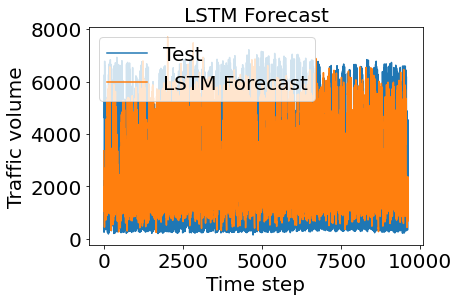

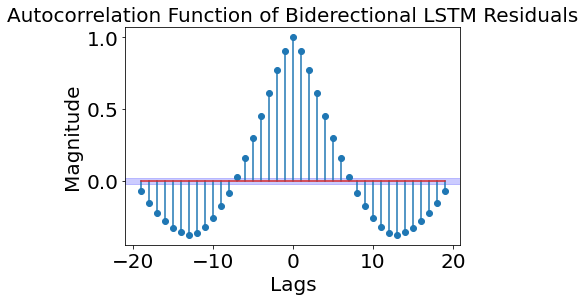

In [89]:
plt.plot(test.ravel()[2:],label='Test')
plt.plot(forecast_main[:-2],label='LSTM Forecast')
plt.legend()
plt.ylabel('Traffic volume')
plt.xlabel('Time step')
plt.title('LSTM Forecast')
plt.show()

f_error= test.ravel()[2:]- forecast_main[:-2]
ACF(f_error,20,'Biderectional LSTM Residuals')

In [90]:
print(f'Variance of Forecast Error: {round(np.var(f_error))}')

Variance of Forecast Error: 6627908


In [91]:
Q= sm.stats.acorr_ljungbox(f_error, lags=[20])
print(f'Qvalue: {Q}')

Qvalue: (array([28693.32268179]), array([0.]))
